In [3]:
import rdflib
import pandas as pd
path = './owlapi.xrdf'
load_format = None

g = rdflib.Graph()
g.load(path, format=load_format)
gdf = pd.DataFrame(iter(g))
gdf = gdf.astype(str)
gdf.columns = ['Entity', 'Property', 'Value']

In [4]:
pain = gdf[gdf.Value == 'Pain']
pain1 = gdf[gdf.Entity.str.contains('http://purl.jp/bio/4/id/200906087442648500')]
pain2 = gdf[gdf.Entity.str.contains('http://purl.jp/bio/4/id/200906012659235956')]
df = pd.concat((pain, pain1, pain2))

In [5]:
import neurolang.datalog.ontologies_parser as op
import importlib
importlib.reload(op)
from neurolang.datalog.ontologies_rewriter import OntologyRewriter

from neurolang.datalog.constraints_representation import DatalogConstraintsProgram
from neurolang.expression_walker import ExpressionBasicEvaluator

from neurolang import frontend as fe

class Datalog(DatalogConstraintsProgram, ExpressionBasicEvaluator):
    pass

paths = ['./owlapi.xrdf']
namespaces = ['http://www.w3.org/2004/02/skos']
onto = op.OntologiesParser(paths, namespaces, graph=df)
nl = fe.NeurolangDL()
datalog_program = onto.parse_ontology(nl.solver)

In [6]:
prob_terms = pd.read_hdf('neurosynth_prob.h5', key='terms')
prob_voxels = pd.read_hdf('neurosynth_prob.h5', key='voxels')
prob_terms_voxels = pd.read_hdf('neurosynth_prob.h5', key='terms_voxels')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [7]:
prob_terms = prob_terms[(prob_terms['index'] == 'pain') |
                        (prob_terms['index'] == 'noxious') |
                        (prob_terms['index'] == 'nociceptive')]

In [8]:
prob_terms_voxels = prob_terms_voxels[
    (prob_terms_voxels.index.get_level_values('term') == 'pain') | 
    (prob_terms_voxels.index.get_level_values('term') == 'noxious') |
    (prob_terms_voxels.index.get_level_values('term') == 'nociceptive')]

In [9]:
prob_terms_voxels.reset_index(inplace=True)
prob_terms_voxels = prob_terms_voxels[['prob', 'term', 'variable']]

In [11]:
from operator import eq
from neurolang.logic import Implication
from nilearn import datasets
import nibabel as nib
from neurolang.frontend.query_resolution import RegionMixin
from neurolang.expressions import ExpressionBlock, Symbol, Constant
from neurolang.logic import Implication
from neurolang.datalog.aggregation import AggregationApplication
import typing
from neurolang.regions import Region

x = Symbol('x')
y = Symbol('y')
z = Symbol('z')
eq_ = Constant(eq)
id_ontology = Symbol('id_ontology')
rel = Symbol('rel')
over = Symbol('over')
name = Symbol('name')

label = Symbol('http://www.w3.org/2000/01/rdf-schema#label')
related = Symbol('http://www.w3.org/2004/02/skos/core#related')
altLabel = Symbol('http://www.w3.org/2004/02/skos/core#altLabel')

@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0]

first_word = nl.symbols.first_word.expression()
first_word.args = (y, )

term = Symbol('term')
term_voxel = Symbol('term_voxel')

#Auditory
imps = tuple()
imps += (Implication(id_ontology(y), label(y, Constant('Pain'))),)
imps += (Implication(rel(y), related(x, y) & id_ontology(x)),)
imps += (Implication(over(y), altLabel(x, y) & rel(x)),)

imps += (Implication(name(z), eq_(z, first_word) & label(x, y) & id_ontology(x)),)
imps += (Implication(name(z), eq_(z, first_word) & over(y)),)
qB2 = ExpressionBlock(imps)

from neurolang.datalog.expressions import TranslateToLogic
from neurolang import expression_walker as ew
from neurolang.datalog.aggregation import DatalogWithAggregationMixin

class DatalogTranslator(
    TranslateToLogic, ew.IdentityWalker, DatalogWithAggregationMixin
):
    pass

dt = DatalogTranslator()
qB2 = dt.walk(qB2)

In [12]:
const = datalog_program.get_constraints()
const = dt.walk(const)

orw = OntologyRewriter(qB2, const)
rewrite = orw.Xrewrite()

In [13]:
from neurolang.datalog import DatalogProgram
from neurolang.datalog.expressions import TranslateToLogic
from neurolang import expression_walker as ew
from neurolang.regions import region_intersection as region_intersection_, ExplicitVBR
from neurolang.datalog.aggregation import DatalogWithAggregationMixin
    
triple = Symbol('triple')
class Datalog2(TranslateToLogic,
    DatalogWithAggregationMixin, DatalogProgram,
    ExpressionBasicEvaluator):
    pass

dl2 = Datalog2()
dl2.add_extensional_predicate_from_tuples(triple, [(a.args[0].value, a.args[1].value, a.args[2].value) for a in onto.triples])

In [14]:
eB2 = ()
for imp in rewrite:
    eB2 += (imp[0],)
    
eB2 = ExpressionBlock(eB2)

dt = DatalogTranslator()
eB22 = dt.walk(eB2)
dl2.walk(eB22)

∪(Implication{λ{S{rel: Unknown}: Unknown}(S{y: Unknown}) ← ⋀(λ{S{http://www.w3.org/2004/02/skos/core#related: Unknown}: Unknown}(S{x: Unknown}, S{y: Unknown}), λ{S{id_ontology: Unknown}: Unknown}(S{x: Unknown}))},
Implication{λ{S{id_ontology: Unknown}: Unknown}(S{y: Unknown}) ← λ{S{triple: Unknown}: Unknown}(S{y: Unknown}, C{'http://www.w3.org/2000/01/rdf-schema#label': str}, C{'Pain': str})},
Implication{λ{S{name: Unknown}: Unknown}(S{z: Unknown}) ← ⋀(λ{C{eq: typing.Callable[[neurolang.type_system.Unknown, neurolang.type_system.Unknown], bool]}: bool}(S{z: Unknown}, λ{C{first_word: typing.Callable[[str], str]}: str}(S{y: Unknown})), λ{S{over: Unknown}: Unknown}(S{y: Unknown}))},
Implication{λ{S{name: Unknown}: Unknown}(S{z: Unknown}) ← ⋀(λ{C{eq: typing.Callable[[neurolang.type_system.Unknown, neurolang.type_system.Unknown], bool]}: bool}(S{z: Unknown}, λ{C{first_word: typing.Callable[[str], str]}: str}(S{y: Unknown})), λ{S{http://www.w3.org/2000/01/rdf-schema#label: Unknown}: Unknown}

In [15]:
from neurolang.datalog.chase import ChaseSemiNaive, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
from neurolang.datalog.aggregation import Chase

class Chase2(
    Chase, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
):
    pass

dc = Chase2(dl2)
solution_instance = dc.build_chase_solution()
list(solution_instance.keys())

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


[S{triple: typing.AbstractSet[typing.Tuple[str, str, str]]},
 S{id_ontology: Unknown},
 S{name: Unknown},
 S{over: Unknown},
 S{rel: Unknown}]

In [16]:
list_words = list(solution_instance['name'].value.unwrapped_iter())

In [19]:
import pickle

file = open("xyz_from_neurosynth.pkl",'rb')
ret = pickle.load(file)
file.close()

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='xyz_from_neurosynth.pkl'>
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
from neurolang.datalog import DatalogProgram
from neurolang.datalog.expressions import TranslateToLogic
from neurolang import expression_walker as ew
from neurolang.regions import region_intersection as region_intersection_, ExplicitVBR
from neurolang.datalog.aggregation import DatalogWithAggregationMixin
from neurolang.probabilistic.probdatalog import (
    ProbDatalogExistentialTranslator,
    GDatalogToProbDatalog,
    ProbDatalogProgram,
    conjunct_formulas,
    is_probabilistic_fact,
    ground_probdatalog_program,
)

dlProb = ProbDatalogProgram()

activated = Symbol('activated')
neurosynth_region = Symbol('neurosynth_region')

dlProb.add_extensional_predicate_from_tuples(activated, set(list_words))
dlProb.add_probfacts_from_tuples(term_voxel, set(prob_terms_voxels.itertuples(index=False, name=None)))
dlProb.add_extensional_predicate_from_tuples(neurosynth_region, [(k, v) for k, v in ret.items()])


In [21]:
from neurolang.region_solver import RegionSolver
class DatalogRegions(
    TranslateToLogic, RegionSolver, DatalogWithAggregationMixin, DatalogProgram, ExpressionBasicEvaluator
):
    pass

from importlib import reload

import neurolang.datalog.chase as ch 
import neurolang.datalog.aggregation as ag
class ChaseP(
    ch.ChaseNaive, ch.ChaseNamedRelationalAlgebraMixin, ch.ChaseGeneral
):
    pass

In [23]:
ans = Symbol('ans')

imps2 = tuple()
imps2 += (Implication(ans(x, y), term_voxel(x, z) & activated(x) & neurosynth_region(z, y)),)
eb = ExpressionBlock(imps2)

dt2 = DatalogTranslator()
eb = dt2.walk(eb)
dlProb.walk(eb)

∪(Implication{λ{S{ans: Unknown}: Unknown}(S{x: Unknown}, S{y: Unknown}) ← ⋀(λ{S{term_voxel: Unknown}: Unknown}(S{x: Unknown}, S{z: Unknown}), λ{S{activated: Unknown}: Unknown}(S{x: Unknown}), λ{S{neurosynth_region: Unknown}: Unknown}(S{z: Unknown}, S{y: Unknown}))})

In [24]:
from neurolang.probabilistic.probdatalog import probdatalog_to_datalog, build_grounding

dl_program = probdatalog_to_datalog(dlProb, datalog=DatalogRegions)
dc = ChaseP(dl_program)
solution_instance = dc.build_chase_solution()
grounded = build_grounding(dlProb, solution_instance)
list(solution_instance.keys())

[S{term_voxel: typing.AbstractSet[typing.Tuple[float, str, int]]},
 S{activated: typing.AbstractSet[typing.Tuple[str]]},
 S{neurosynth_region: typing.AbstractSet[typing.Tuple[int, neurolang.regions.ExplicitVBR]]},
 S{ans: Unknown}]

In [25]:
from importlib import reload
import neurolang.probabilistic.probdatalog_gm as asd

gm = asd.TranslateGroundedProbDatalogToGraphicalModel().walk(grounded)
query = asd.SuccQuery(ans(x, z))
solver = asd.QueryGraphicalModelSolver(gm)
result = solver.walk(query)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


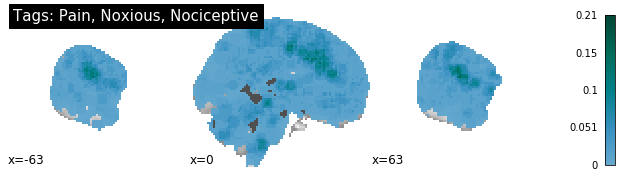

In [34]:
result_data = result.value.to_numpy()
import numpy as np
prob_img = nib.spatialimages.SpatialImage(
    np.zeros(result_data[0][3].image_dim, dtype=float),
    affine=result_data[0][3].affine
)

for p in result_data:
    prob_img.dataobj[tuple(p[3].voxels.T)] = p[0]/prob_terms[prob_terms['index'] == p[2]]['proba'].values[0]

from nilearn import plotting

plotting.plot_stat_map(
    prob_img, 
    title='Tags: Pain, Noxious, Nociceptive', 
    cmap='PuBuGn',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 3),
)